# Noise analysis

In [1]:
#%matplotlib notebook
%matplotlib inline
import bz2, os, time
from os import path
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats, interpolate
from scipy.optimize import curve_fit
import matplotlib.dates as mdate
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
from IPython.display import display
#from my_funcs import getfiles, natural_sort_key, cumsum_sma

sns.set_context("talk")

PLOT_DIR = Path("./plots")
PLOT_DIR.mkdir(exist_ok=True)

DATA_DIR = Path("./data/Oszi/step3/")
DATA_DIR.mkdir(exist_ok=True)

B1500A_DIR = Path("./data/B1500A/step1/")
#B1500A_DIR.mkdir(exist_ok=True)

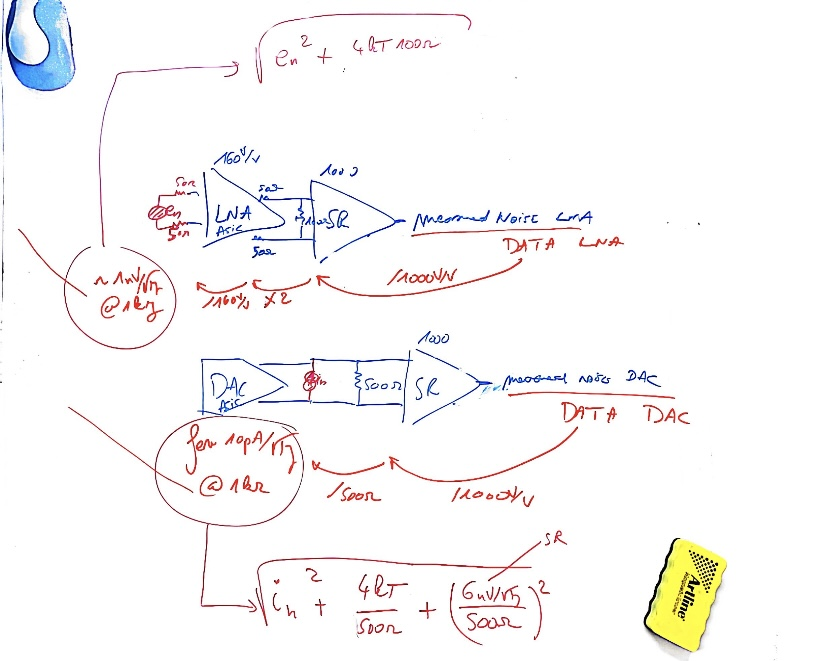

In [2]:
img = Image.open('img/IMG_5794.jpg')
display(img)

* Output data at LNA has been multiplied by 160 times by LNA, then divide by 2 by resistance , multiplied to 1000 by SR. Then to calculate the input noise, we follow the equation
  $$ n_i = \frac{2 \cdot n_{out}}{1000 \cdot 160} = \frac{n_{out}}{80000} $$
  In fact, the noise is the combination of voltage noise $e_n^2$ and thermal noise of resistance, then
  $$ n_i = \sqrt{e_n^2 + 4kT100} = \frac{n_{out}}{80000} \Rightarrow e_n = \sqrt{\frac{n_{out}^2}{80000^2} - 4kT100}  [V/\sqrt{Hz}]$$
  (T is the temperature at room temperature ($300 [K]$), k is the Boltzman constant $1.38e-23 [J/K] $)

* Output data at DAC has been multiplied by $500 \Omega$ resistance to convert from current to voltage, then multiplied by 1000 by SR.To calculate the input noise, we follow the equation
  $$ n_i = \frac{n_{out}}{1000*500} = \frac{n_{out}}{500000} $$
  In fact, the noise is the combination of current noise $i_n^2$ and thermal noise of resistance, then the noise from SR.
  $$ n_i = \sqrt{i_n^2 + \frac{4kT}{500} + (\frac{6e-9}{500})} \Rightarrow i_n = \sqrt{\frac{n_{out}^2}{500000^2} - \frac{4kT}{500} - \frac{6}{500e9}} $$

In [3]:
DATA_DIR = './data/Oszi/'

In [700]:
def dat_conv(data, type):
    k = 1.38e-23
    T = 300
    noise = []
    
    if type == 'LNA':
        noise = [((a/80000)**2 - 4*k*T*25) for a in data]
        noise = np.array(noise)
        ind = np.where(noise > 0)
        noise = np.sqrt(noise[ind[0]])*1e9
        # noise = [a/80000 for a in data]
    elif type == 'DAC':
        noise = [((dat*1e12/500000)**2 - 4*k*T*(1e12)**2/500 - (6*1e3 /500)**2) for dat in data]
        noise = np.array(noise)
        ind = np.where(noise > 0)
        noise = np.sqrt(noise[ind[0]])
        # 1e3 to convert nV to pV, this factor was itself nV, don't need to convert from V to nV
        # noise = [(dat/500000) for dat in data]
        
    return noise,ind

def sort_data(DATA_DIR, step, number, type, f):
    DATA_DIR = DATA_DIR + step + '/'
    DATA_DIR = Path(DATA_DIR)
    
    file_name = [f for f in os.listdir(DATA_DIR) if f.endswith('.TXT')]
    #print('done')
    # number: from 1 to  7 (number the board we use)
    # type: '['D'] for DAC, ['L'] for LNA, or ['D','L'] for both
    #f: ['L'] for low frequency, ['H'] for high frequency, ['L','H'] for both
    
    # DATA_path = 
    #Sort the name of file we want
    name_var = []
    for name in file_name:
        if name and name[2] in type and int(name[1]) in number and name[3] in f:
                name_var.append(name)
                #sort it by number
    name_var = sorted(name_var, key=lambda x: int(x[1]))
    #print(name_var)
    f_noise = []
    noise_val = []
    for i in range(len(name_var)):
        # Construct the full file path
        file_path = os.path.join(DATA_DIR, name_var[i])

        
        # Load the data from the file
        f_data, data = np.loadtxt(file_path, unpack=True, encoding='utf-8')
        # f_noise.append(f_data)
        np.append(f_noise,f_data)
        if name_var[i][2] == 'L':
            noise_val.append(dat_conv(data, 'LNA')[0])
            # print(noise_val)
            noise = np.array(f_noise)
            # print(f_noise)
            f_noise = f_noise[0][dat_conv(data, 'LNA')[1][0]]
            noise_val = noise_val[0]
        elif name_var[i][2] == 'D':
            noise_val.append(dat_conv(data, 'DAC')[0])
            # print(dat_conv(data, 'DAC')[1][0])
            noise_val = np.array(noise_val)
            # print(f_noise)
            f_noise = f_noise[0][dat_conv(data, 'DAC')[1][0]]
            noise_val = noise_val[0]
    # print(f'There are {len(name_var)} files in the sorted list, they are {name_var}')
    # print(f_noise)
    # print(noise_val)
    # print(name_var)
    return f_noise, noise_val, name_var
    # if noise_val[0] > 0: 
        # return f_noise, noise_val[0], name_var
    # else:
        # print('nah')

In [641]:
dose_rate = [0.036, 0.036, 0.035, 0.36, 36, 36]
total_dose = [6,12,18,36,100,200]

In [680]:
f0,val0, name0 = sort_data(DATA_DIR, 'step1', [5], ['L'], ['L'])

In [643]:

print((len(f0)))
print((len(val0)))

390
390


In [677]:
def plot_noise(board_number,type, F):
    dir_sv1 = f'board{board_number[0]}'
    f0,val0, name0 = sort_data(DATA_DIR, 'step0', board_number, type, F)
    f1,val1, name1 = sort_data(DATA_DIR, 'step1', board_number, type, F)
    f2,val2, name2 = sort_data(DATA_DIR, 'step2', board_number, type, F)
    f3,val3, name3 = sort_data(DATA_DIR, 'step3', board_number, type, F)
    f4,val4, name4 = sort_data(DATA_DIR, 'step4', board_number, type, F)
    f5,val5, name5 = sort_data(DATA_DIR, 'step5', board_number, type, F)
    f6,val6, name6 = sort_data(DATA_DIR, 'step6', board_number, type, F)
    # f7,val7, name7 = sort_data(DATA_DIR, 'step7', board_number, type, F)
    
    
    # plt.figure(figsize = (15,10))
    if type[0] == 'D':
        if len(F) > 1:
            f = 'DAC_LF_HF'
        else:
            if F[0] == 'L':
                f = 'DAC_LF'
            elif F[0] == 'H':
                f = 'DAC_HF'
        # label = '$\sqrt{i_n^2 + \frac{4kT}{500} + (\frac{6nV/\sqrt{Hz}}{500})} [A/\sqrt{Hz}]$'
        plt.ylabel(r'$\sqrt{i_n^2 + \frac{4kT}{500} + (\frac{6nV/\sqrt{Hz}}{500})} [A/\sqrt{Hz}]$')
    if type[0] == 'L':
        if len(F) > 1:
            f = 'LNA_LF_HF'
        else:
            if F[0] == 'L':
                f = 'LNA_LF'
            elif F[0] == 'H':
                f = 'LNA_HF'
        # label = '$\sqrt{i_n^2 + \frac{4kT}{500} + (\frac{6nV/\sqrt{Hz}}{500})} [A/\sqrt{Hz}]$'
        plt.ylabel(r'$\sqrt{e_n^2 + 4kT100} [V/ \sqrt{Hz}] $')   

    color_band = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']    
    name =   f'Noise_Board{board_number[0]}_' + f + '_Different Dose rate' 
    
    plt.title(f'{name}')
    # if type[0] == 'D':
    #     plt.axhline(y = 10e-12, lw = 2)
    # elif type[0] == 'L':
    #     plt.axhline(y = 1e-9, lw = 2)
    print(f' name length = {len(name0)}')
    # print(f' f = {f0}')
    # print(f' val = {val0}')
    # for i in range(len(val0)):
    #     step = 'step' + f'{name0[0][5]}'  
    #     plt.plot(f0[i],val0[i], color = color_band[0],lw = 1, label = f'{step}')
        
    # for i in range(len(val1)):
    #     step = 'step' + f'{name1[0][5]}'
    #     plt.plot(f1[i],val1[i], color = color_band[1],lw = 1, label = f'{step}')
        
    # for i in range(len(val2)):
    #     step = 'step' + f'{name2[0][5]}'
    #     plt.plot(f2[i],val2[i], color = color_band[2],lw = 1, label = f'{step}')
        
    # for i in range(len(val3)):
    #     step = 'step' + f'{name3[0][5]}'
    #     plt.plot(f3[i],val3[i], color = color_band[3],lw = 1 ,label = f'{step}')
        
    # for i in range(len(val4)):
    #     step = 'step' + f'{name4[0][5]}'
    #     plt.plot(f4[i],val4[i], color = color_band[4],lw = 1, label = f'{step}')
        
    # for i in range(len(val5)):
    #     step = 'step' + f'{name5[0][5]}'
    #     plt.plot(f5[i],val5[i], color = color_band[5],lw = 1, label = f'{step}')
        
    # for i in range(len(val6)):
    #     step = 'step' + f'{name6[0][5]}'
    #     plt.plot(f6[i],val6[i], color = color_band[6],lw =1, label = f'{step}')
        
    # for i in range(len(val7)):
    #     step = 'step' + f'{name7[0][5]}'
    #     plt.plot(f7[i],val7[i],color = color_band[7],lw = 1, label = f'{step}')

    
    step = 'step' + f'{name0[0][5]}'  
    plt.plot(f0,val0, color = color_band[0],lw = 1, label = f'{step}')
    

    step = 'step' + f'{name1[0][5]}'
    plt.plot(f1,val1, color = color_band[1],lw = 1, label = f'{step}')
    

    # step = 'step' + f'{name2[0][5]}'
    # plt.plot(f2,val2, color = color_band[2],lw = 1, label = f'{step}')
    

    step = 'step' + f'{name3[0][5]}'
    plt.plot(f3,val3, color = color_band[3],lw = 1 ,label = f'{step}')
    

    step = 'step' + f'{name4[0][5]}'
    plt.plot(f4,val4, color = color_band[4],lw = 1, label = f'{step}')
    

    # step = 'step' + f'{name5[0][5]}'
    # plt.plot(f5,val5, color = color_band[5],lw = 1, label = f'{step}')
    

    # step = 'step' + f'{name6[0][5]}'
    # plt.plot(f6,val6, color = color_band[6],lw =1, label = f'{step}')
    

    # step = 'step' + f'{name7[0][5]}'
    # plt.plot(f7,val7,color = color_band[7],lw = 1, label = f'{step}')
    plt.xscale('log')
    plt.yscale('log')
    #plt.ylabel(f'{label}')
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.legend(loc = 'upper right')
    plt.savefig('1.png')
    # plt.savefig(f'plots/{dir_sv1}/{name}.png')

In [678]:
def find_nearest_frequency_indices(f, f_specify):
    indices = []
    for f_value in f_specify:
        if f_value < np.min(f) or f_value > np.max(f):
            continue
        nearest_index = np.where(np.logical_and(f >= f_value - 2.5, f <= f_value + 2.5))[0]
        indices.extend(nearest_index)
    return indices

 name length = 1
done


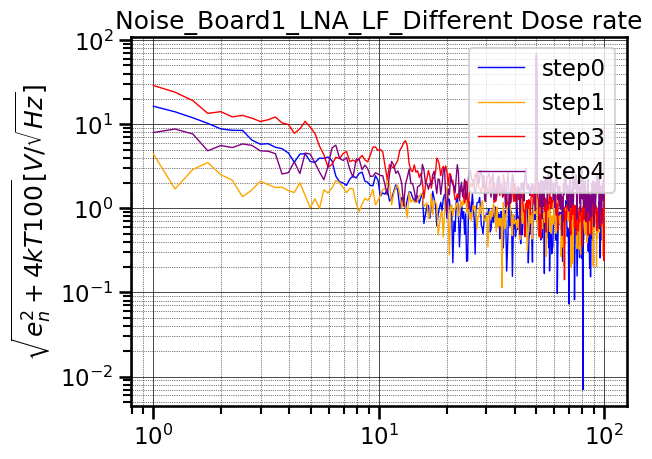

In [679]:
# Board 1,2,3,4,5,6

num = [[1],[2],[3],[4],[5],[6]]
num = [[1]]
#-----------------
type = ['L']
F = ['L']
for i in num:
    plot_noise(i,type,F)
#-----------------
# type = ['D']
# F = ['H']
# for i in num:
#     plot_noise(i,type,F)
# #-----------------
# type = ['D']
# F = ['L','H']
# for i in num:
#     plot_noise(i,type,F)
#-----------------
# #-----------------
# type = ['L']
# F = ['L']
# for i in num:
#     plot_noise(i,type,F)
# #-----------------
# type = ['L']
# F = ['H']
# for i in num:
#     plot_noise(i,type,F)
# #-----------------
# type = ['L']
# F = ['L','H']
# for i in num:
#     plot_noise(i,type,F)
# #-----------------









print('done')

# Masking 

In [300]:
def join(f1,f2,a1,a2):
    f1 = np.array(f1)
    f2 = np.array(f2)
    a1 = np.array(a1)
    a2 = np.array(a2)
    # print(len(a1))
    # Step 1: Find matching indices
    matching_indices = np.where(np.isin(f1, f2))[0]
    
    # Step 2: Calculate average of a1 and a2 for matching indices
    a_avg = (a1[matching_indices] + a2[np.isin(f2, f1)]) / 2
    
    # Step 3: Concatenate non-matching values
    f_combined = np.concatenate((f1, f2[np.isin(f2, f1, invert=True)]))
    a_combined = np.concatenate((a1, a2[np.isin(f2, f1, invert=True)]))
    
    # Concatenate matching values with averaged a values
    f_combined = np.concatenate((f_combined, f1[matching_indices]))
    a_combined = np.concatenate((a_combined, a_avg))
    
    # Sort the combined arrays based on the frequency values
    sort_indices = np.argsort(f_combined)
    f_combined = f_combined[sort_indices]
    a_combined = a_combined[sort_indices]
    return f_combined,a_combined
# board_number = [3]
# step = 'step1'
# type = ['D']

# f1,val1, name1 = sort_data(DATA_DIR, step , board_number, type, 'L')
# f2,val2, name2 = sort_data(DATA_DIR, step , board_number, type, 'H')
# print(len(val1[0]))
# f_n,val_n = join(f1[0],f2[0],val1[0],val2[0])

# Masking and Concentratre

In [392]:
def plot_noise_masking(board_number,type):
    dir_sv1 = f'board{board_number[0]}'
    
    f_peak = [50,60,70,75,90,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]
    fl = 1000
    step_arr = ['step0','step1','step2','step3','step4','step5','step6','step7','step8']
    f_type = ['L','H']
    f_val = []
    val = []
    name = []
    color_band = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']  
    for step in step_arr:
        f1,val1, name1 = sort_data(DATA_DIR, step , board_number, type, 'L')
        f2,val2, name2 = sort_data(DATA_DIR, step , board_number, type, 'H')
        if len(f1) == 0 or len(f2) == 0:
            continue
        else:
            #------ Masking -------
            f_join1,val_join1 = join(f1[0],f2[0],val1[0],val2[0])
            # f_join1,val_join1 = join(f1,f2,val1,val2)
            ind = find_nearest_frequency_indices(f_join1, f_peak)
            f_join1 = np.delete(f_join1,ind)
            val_join1 = np.delete(val_join1,ind)
            ind = np.where(f_join1<fl)
            f_join1 = f_join1[ind]
            val_join1 = val_join1[ind]
            val_join1 = val_join1*1e9
            f_val.append(f_join1)
            val.append(val_join1)
            name.append(step)

    plt.figure(figsize = (15,10))
    if type[0] == 'D':
        f = 'DAC'
        # label = '$\sqrt{i_n^2 + \frac{4kT}{500} + (\frac{6nV/\sqrt{Hz}}{500})} [A/\sqrt{Hz}]$'
        plt.ylabel(r'$\sqrt{i_n^2 + \frac{4kT}{500} + (\frac{6nV/\sqrt{Hz}}{500})} [nA/\sqrt{Hz}]$')
    elif type[0] == 'L':
        f =  'LNA'
        # label = '$\sqrt{i_n^2 + \frac{4kT}{500} + (\frac{6nV/\sqrt{Hz}}{500})} [A/\sqrt{Hz}]$'
        plt.ylabel(r'$\sqrt{e_n^2 + 4kT100} [nV/ \sqrt{Hz}] $')   

        
    name1 =   f'Noise_Board{board_number[0]}_' + f 
    # guess = np.array([0,0,0.5])
    plt.title(f'{name1}')
    if type[0] == 'D':
        plt.axhline(y = 10e-12* 1e9, lw = 2)
    elif type[0] == 'L':
        plt.axhline(y = 1e-9*1e9, lw = 2)
        
    for i in range(len(name)):    
        plt.plot(f_val[i],val[i],lw = 1,color = color_band[int(name[i][4])], label=f"{name[i]}")
    plt.xlabel('Frequency (Hz)')
    plt.xscale('log')
    plt.yscale('log')
    #plt.ylabel(f'{label}')
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.legend(loc = 'upper right')
    # plt.savefig(f'plots/{dir_sv1}/{name}.png')

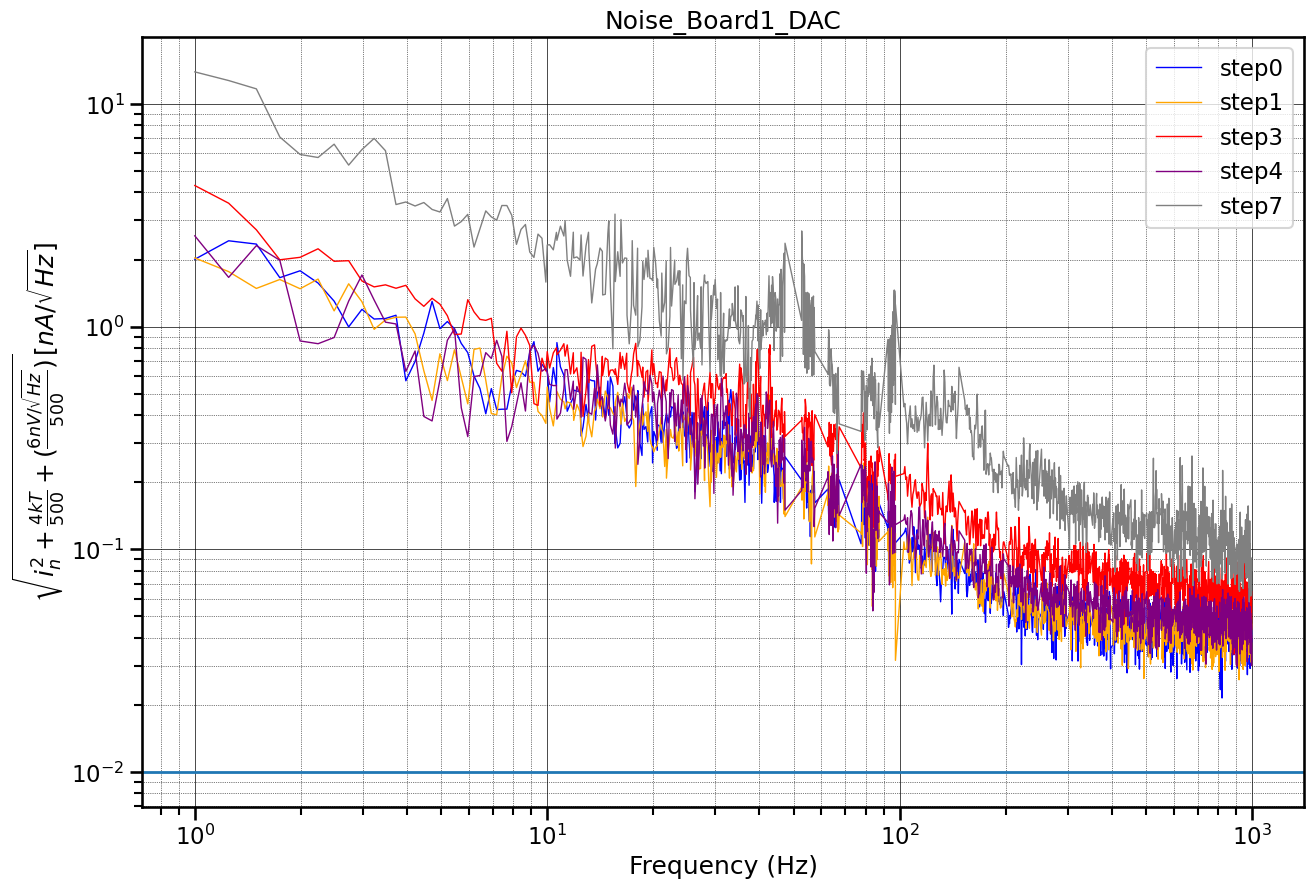

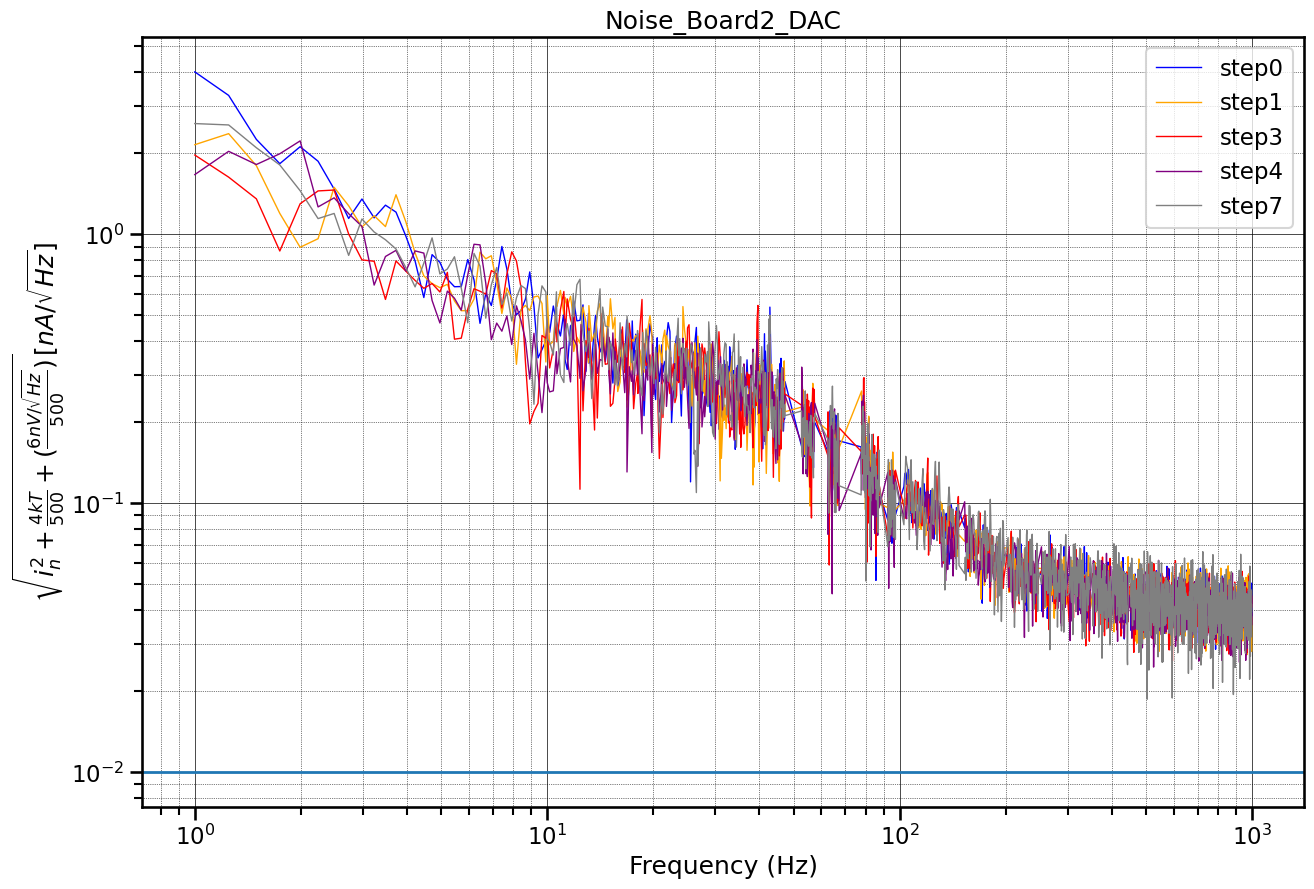

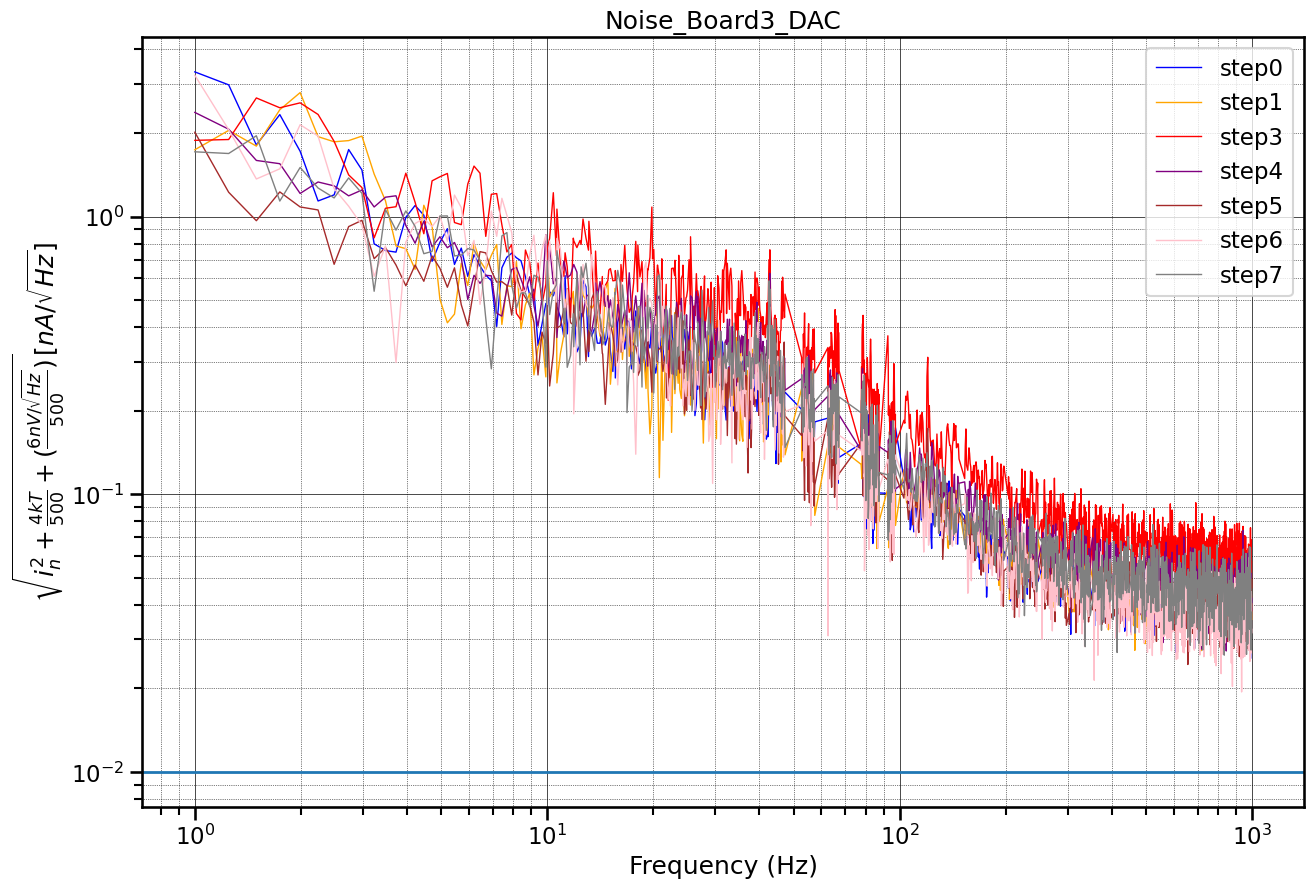

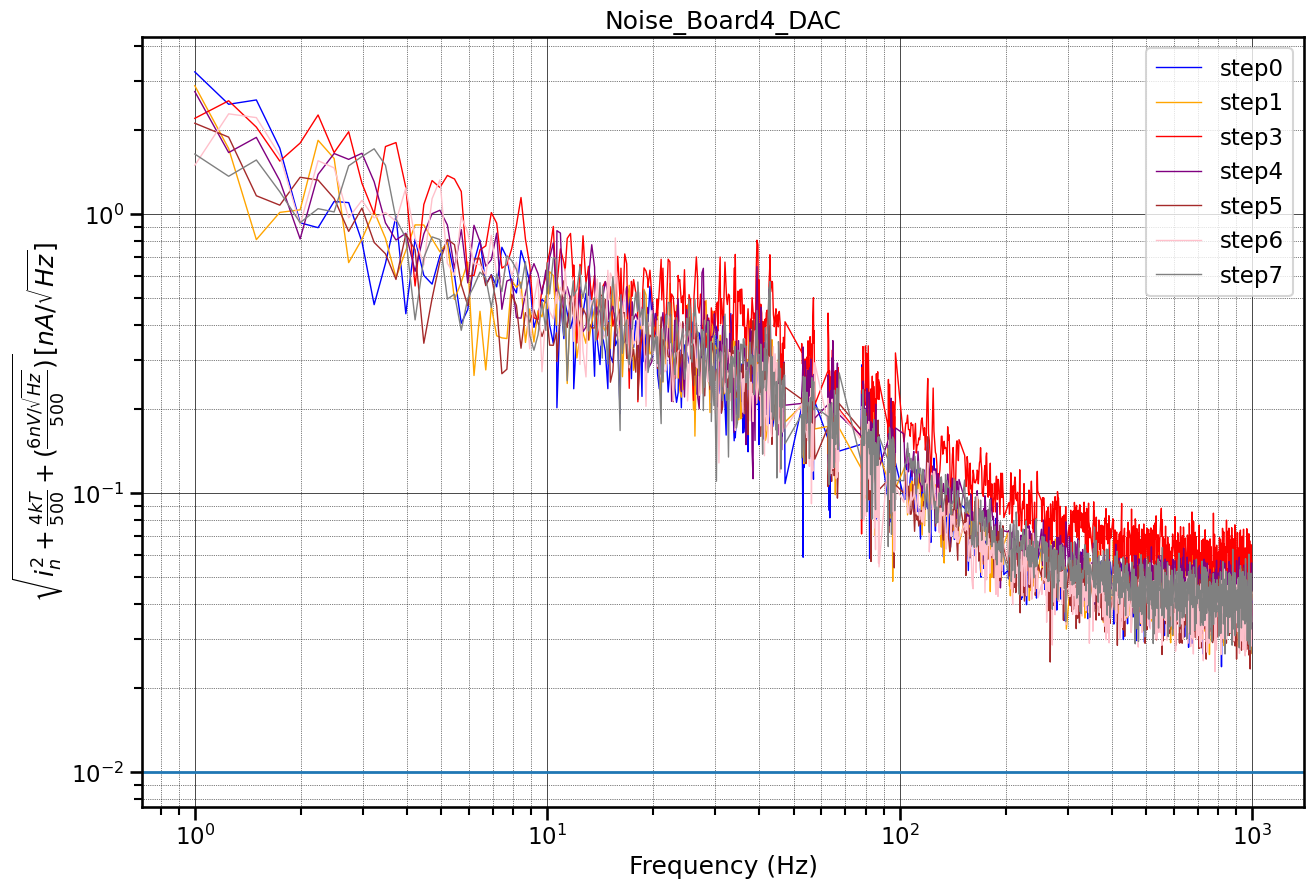

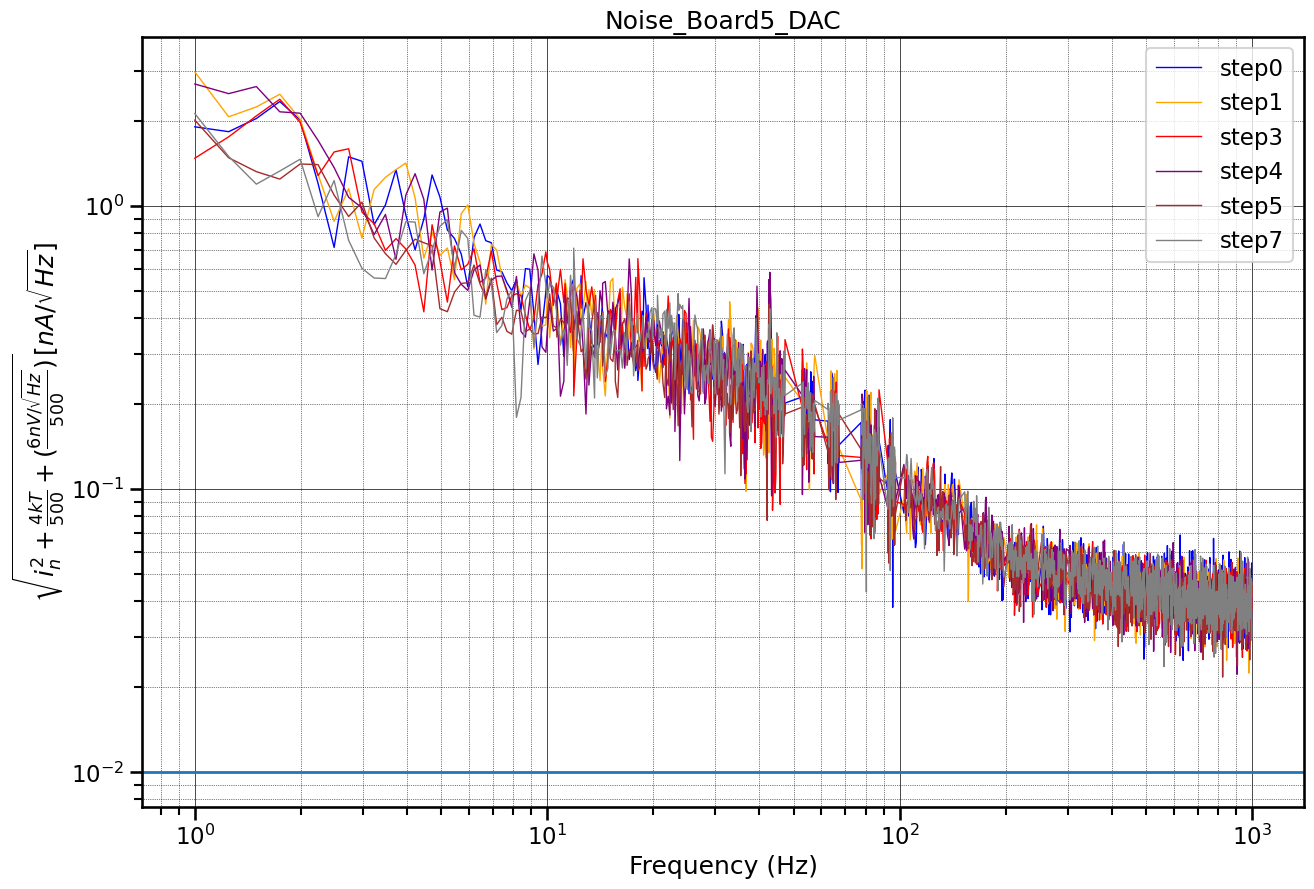

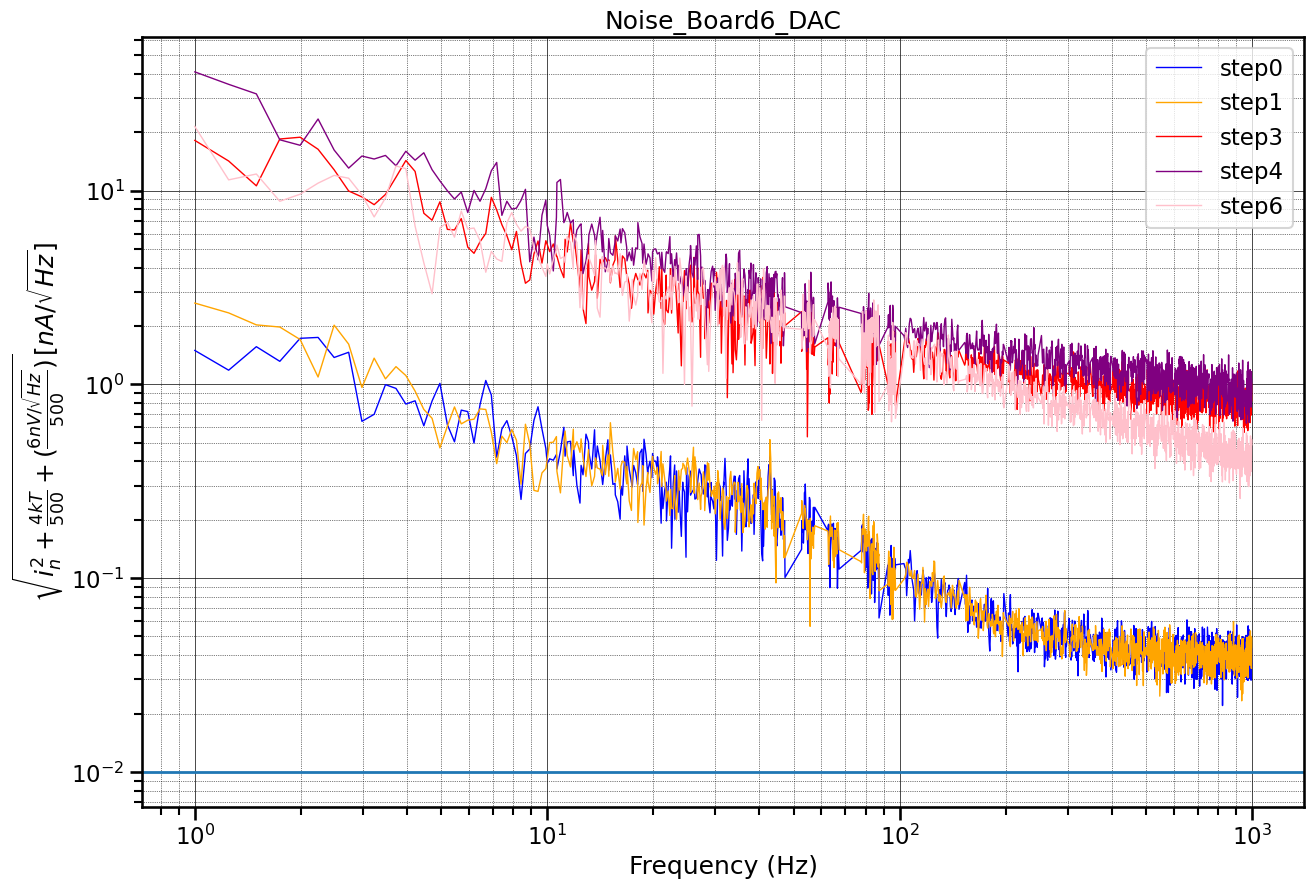

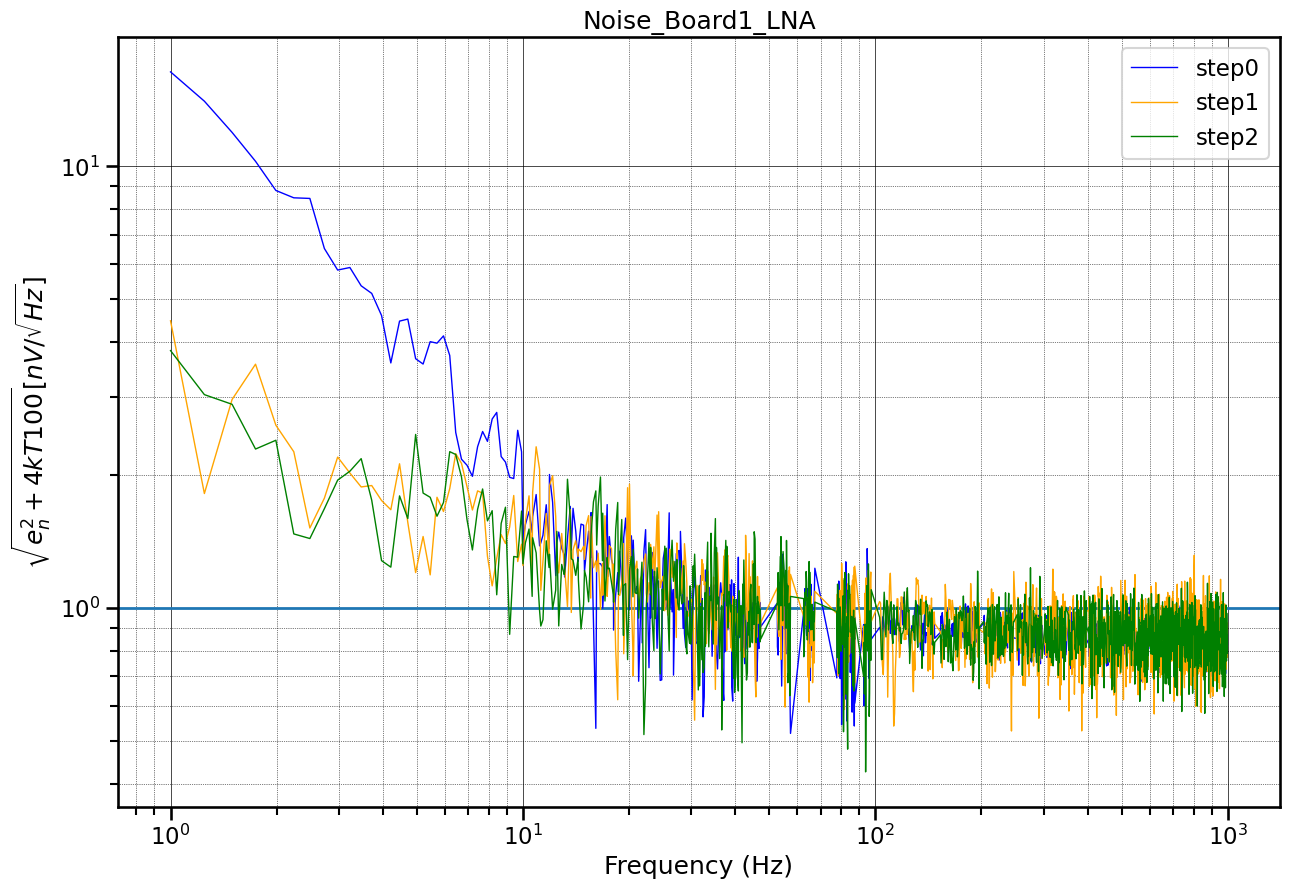

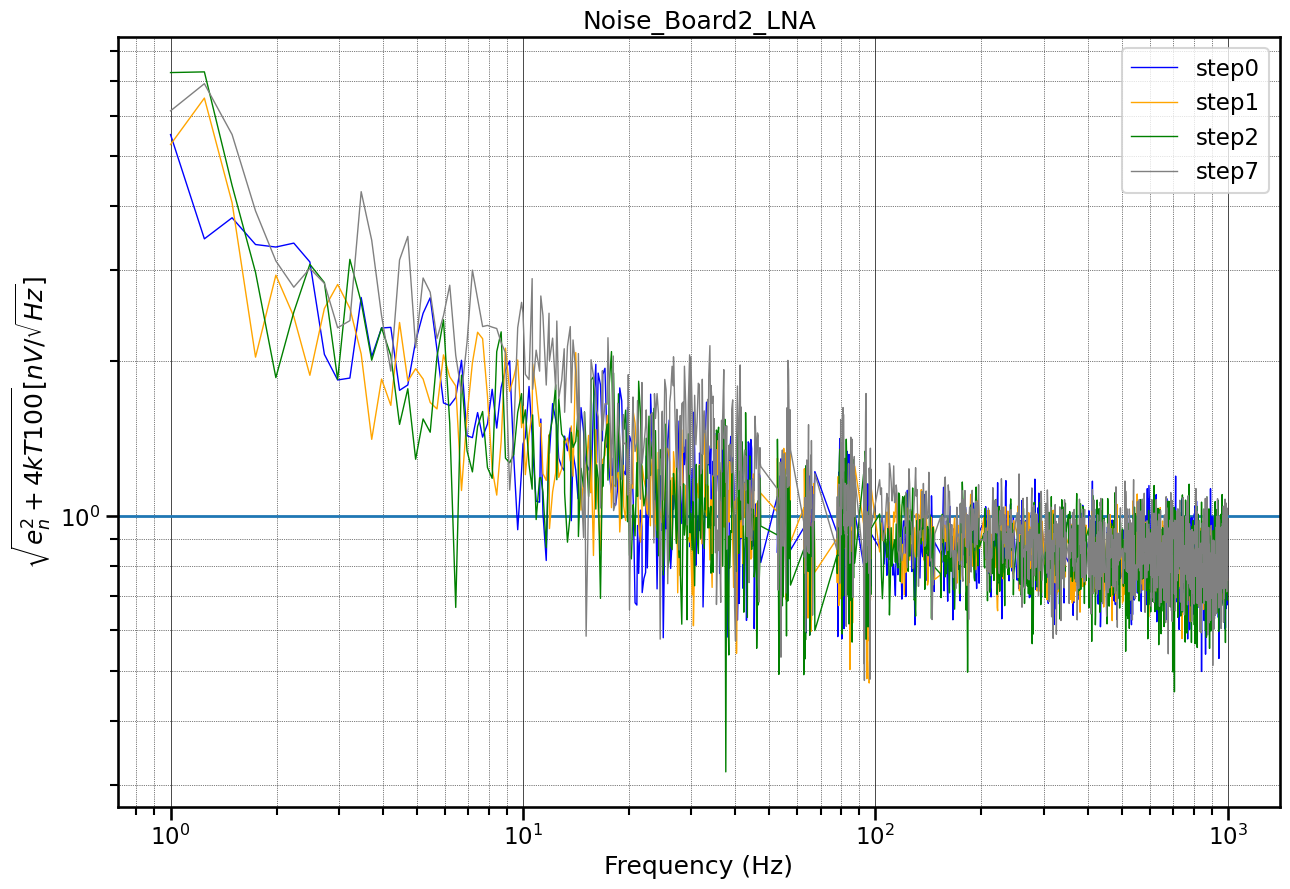

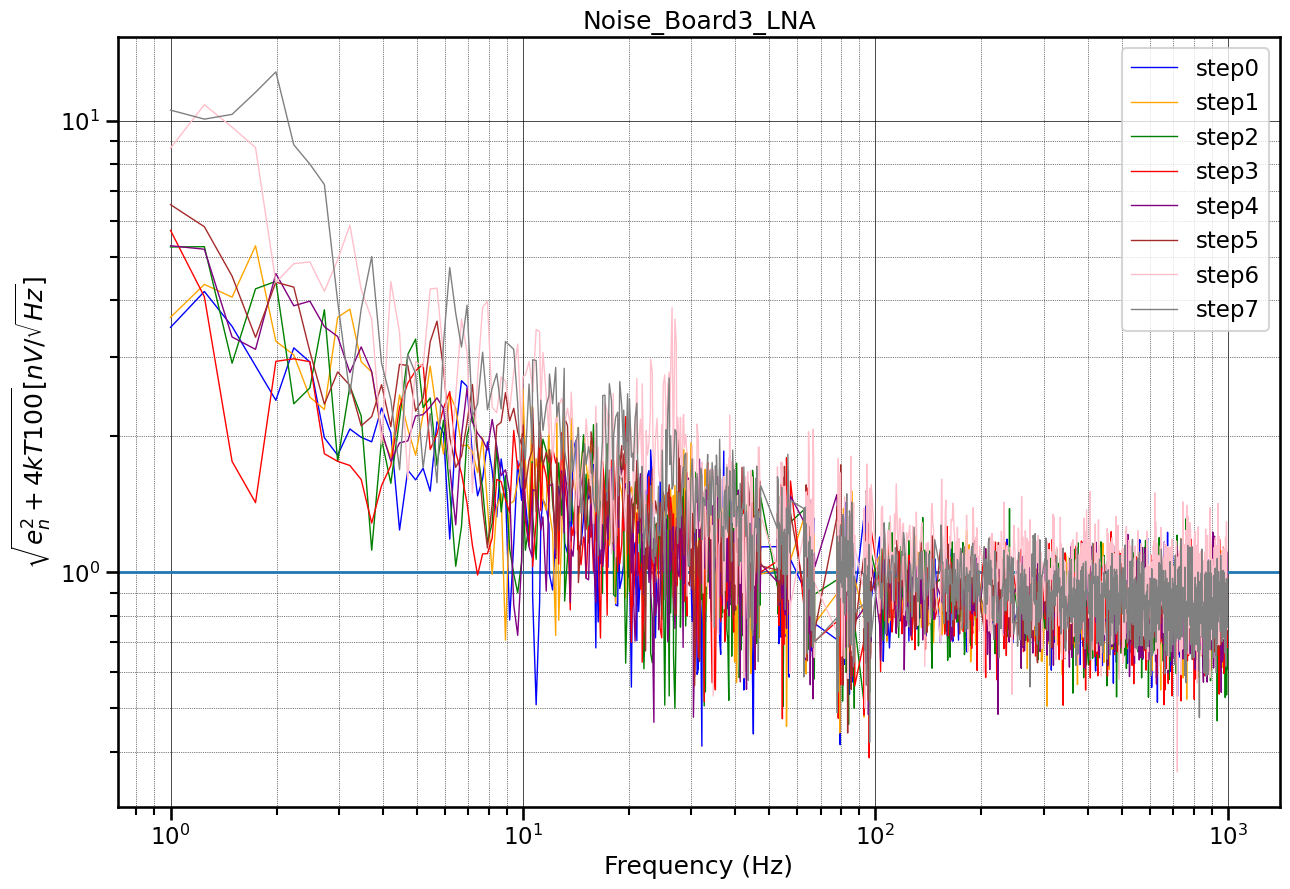

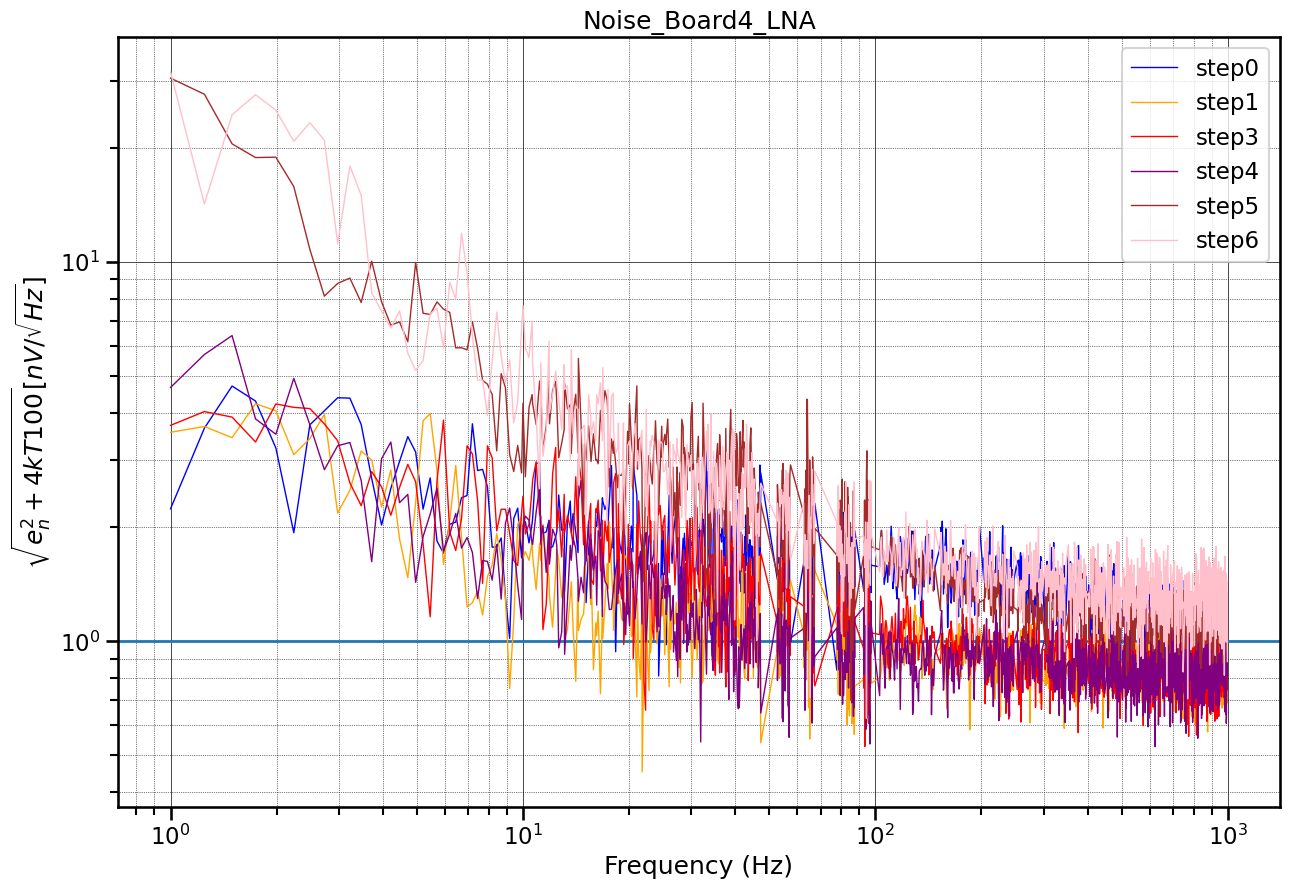

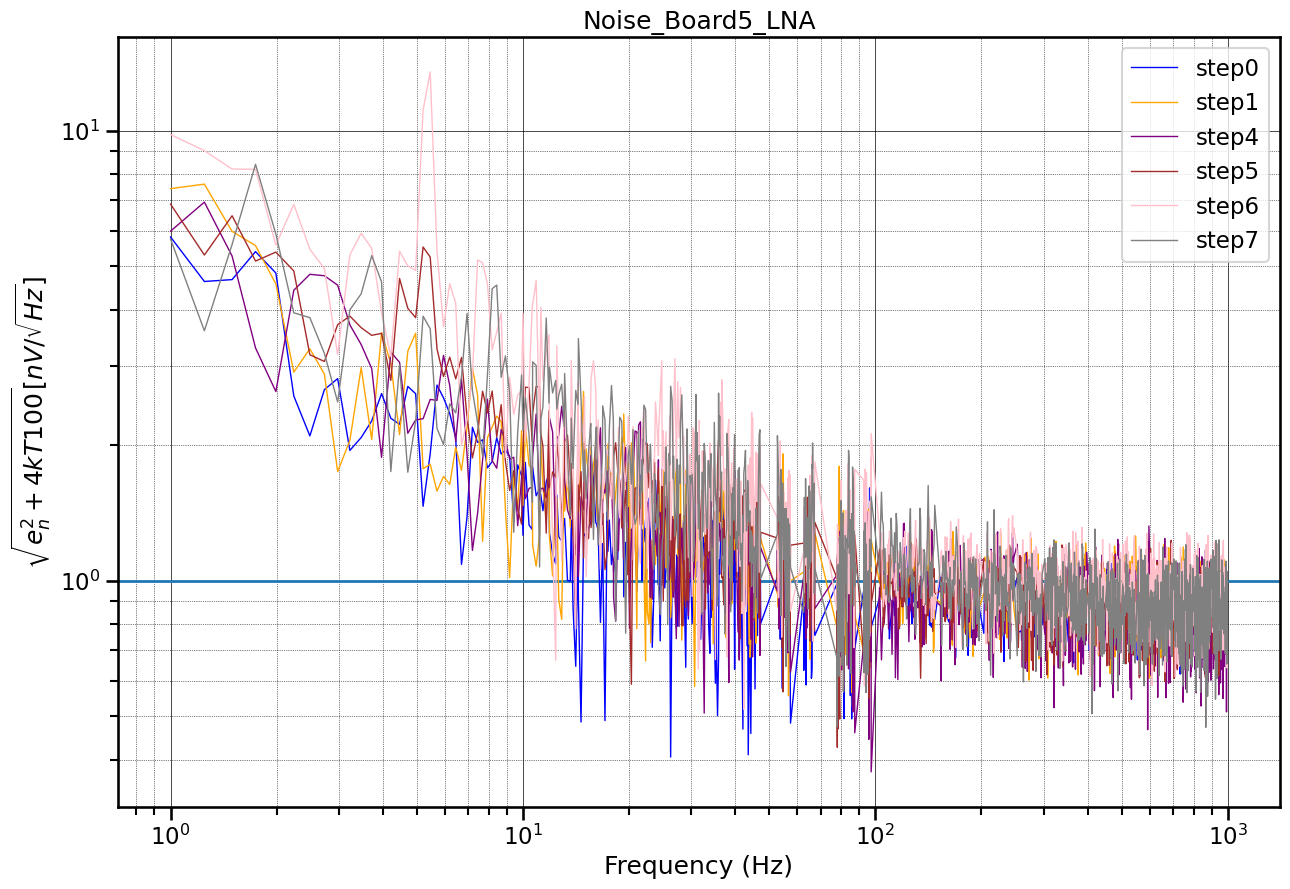

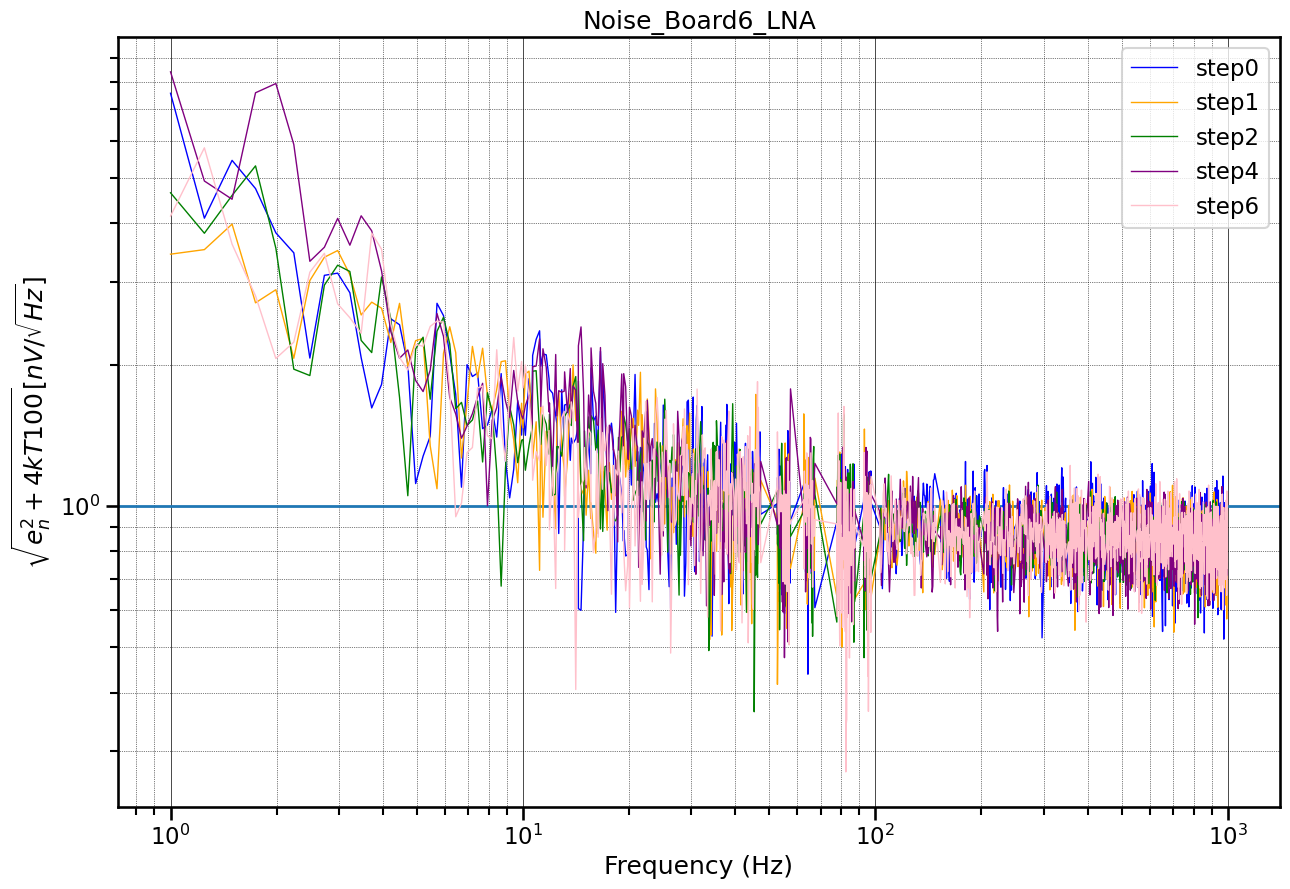

In [393]:
num = [[1],[2],[3],[4],[5],[6]]
#-----------------
type = ['D']
for i in num:
    plot_noise_masking(i,type)
# #-----------------
type = ['L']
for i in num:
    plot_noise_masking(i,type)

# Fit

In [349]:
def find_nearest_frequency_indices(f, f_specify):
    indices = []
    for f_value in f_specify:
        if f_value < np.min(f) or f_value > np.max(f):
            continue
        nearest_index = np.where(np.logical_and(f >= f_value - 2.5, f <= f_value + 2.5))[0]
        indices.extend(nearest_index)
    return indices

In [380]:
def chi_square(dat_obs,dat_fit):
    chi = 0
    for i in range(len(dat_obs)):
        chi = chi + (dat_obs[i] - dat_fit[i])**2/(dat_fit[i]**2)
    return round(chi,3)

In [681]:
def plot_noise_join_et_fit(board_number,type,step,des):
    dir_sv1 = f'board{board_number[0]}'

    def fit_curve(x,a,b):
        if type[0] == 'L':
            return np.sqrt(a**2 + (b*x**(-0.5))**2)
        elif type[0] == 'D' :
            # return (np.abs(a)+ (b*x**(-c)))
            a =  0
            return ((b*x**(-0.5)))

    
    
    f_peak = [40,45,50,70,75,80,90,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]
    fl = 1000
    # step_arr = ['step0','step1','step2','step3','step4','step5','step6','step7','step8','step9']
    step_arr = np.array(step)
    f_type = ['L','H']
    f_val = []
    val = []
    name = []
    for step in step_arr:
        f1,val1, name1 = sort_data(DATA_DIR, step , board_number, type, 'L')
        f2,val2, name2 = sort_data(DATA_DIR, step , board_number, type, 'H')
            #-------joining--------

        #test f1
        print(f1)
        
        if len(f1) == 0 or len(f2) == 0:
            continue 
        else:
            #------ Masking -------
            # f_join1,val_join1 = join(f1[0],f2[0],val1[0],val2[0])
            f_join1,val_join1 = join(f1,f2,val1,val2)
            # f_join1,val_join1 = join(f1,f2,val1,val2)
            ind = find_nearest_frequency_indices(f_join1, f_peak)
            f_join1 = np.delete(f_join1,ind)
            val_join1 = np.delete(val_join1,ind)
            ind = np.where(f_join1<fl)
            f_join1 = f_join1[ind]
            val_join1 = val_join1[ind]
            val_join1 = val_join1*1
            f_val.append(f_join1)
            val.append(val_join1)
            name.append(step)
            
    
    plt.figure(figsize = (15,10))
    if type[0] == 'D':
        f = 'DAC'
        fac = 1
        # label = '$\sqrt{i_n^2 + \frac{4kT}{500} + (\frac{6nV/\sqrt{Hz}}{500})} [A/\sqrt{Hz}]$'
        plt.ylabel(r'$\sqrt{i_n^2 + \frac{4kT}{500} + (\frac{6nV/\sqrt{Hz}}{500})} [pA/\sqrt{Hz}]$')
    elif type[0] == 'L':
        f =  'LNA'
        fac = 1
        # label = '$\sqrt{i_n^2 + \frac{4kT}{500} + (\frac{6nV/\sqrt{Hz}}{500})} [A/\sqrt{Hz}]$'
        plt.ylabel(r'$\sqrt{e_n^2 + 4kT100} [nV/ \sqrt{Hz}] $')   

        
    name1 =   f'Noise_Board{board_number[0]}_' + f 
    
    # guess = np.array([0,0,0.5])
    plt.title(f'{name1}')
    # if type[0] == 'D':
    #     plt.axhline(y = 10e-12*fac* 1e9, lw = 2)
    # elif type[0] == 'L':
    #     plt.axhline(y = 1e-9*fac*1e9, lw = 2)
    
    color_band = ['blue','orange','green','red','purple','brown','pink','black','olive','cyan']
    # print(name)
    
    for i in range(len(name)):   
        val[i] = val[i]*fac
        col = color_band[int(name[i][4])]
        plt.plot(f_val[i],val[i],lw = 1, color = col)
    
        #---split--------
        beg = 550 #starting point of white noise

        
        fl = f_val[i][beg]
        ind = np.where(f_join1<fl)
        f_join = f_val[i][ind]
        val_join = val[i][ind]
        #flip
        # f_join = f_join[::1]
        # val_join = val_join[::1]
        #---fiting-------
        


        
        
        x_val = f_join
        y_val = val_join
        a_guest = np.mean(val[i][beg:-1])

        #------
        guess = np.array([a_guest, val[i][0]])
     
        a_values = []
        b_values = []

      #White noise array
        w_n = np.ones(len(f_val[i]))*a_guest
 
        for _ in range(100):
            popt, _ = curve_fit(fit_curve, x_val, y_val, guess, maxfev=500000)
            a, b = popt
            a_values.append(a)
            b_values.append(b)
        
            # Update guess with the values of a, b, and c for the next fit
            guess = np.array([a, b])

        
        # Perform any other operations using the updated values of a, b, and c
        # y_new = fit_curve(x_val,a,  b, c)
        f_mode = f_val[i][1:beg]
        y_new = fit_curve(f_mode,a,  b)
        # y_new = y_new[::1]
        
        # c = 0.5
        #Flicker noise array
        f_n = fit_curve(f_val[i], a, b) 
        
        t_n = np.sqrt(f_n**2 + w_n**2)
        
        #find f_c
        distances = np.abs(a_guest - fit_curve(f_val[i],a,  b))
        min_distance_index = np.argmin(distances)
        
        # fc = min_distance_index + 1  # Add 1 because the index is zero-based
        f_mode = f_val[i][min_distance_index]
        
        # print(np.size(t_n))
        if type[0] == 'D':
            chisquare = chi_square(val[i],t_n)
            # plt.plot(f_val[i], t_n,lw = 2, zorder = 5, label=f"Board {board_number[0]}, {name[i]}. $\sqrt{{({np.abs(round(a, 3))} + {round(b, 3)} / f^{ {round(c, 3)} })^2 + {round(a_guest, 3)}^2}}$, fc = {f_mode} Hz")
            plt.plot(f_val[i], t_n,lw = 2, zorder = 5,color = col, label=f"{name[i]}, a= {round(a_guest,3)}, b = {round(b,3)}, $\chi^2$ = {chisquare}")
            
            if des == 1:
                plt.axhline(y = a_guest,color = 'black',linestyle = 'dashed')
                plt.axvline(x = f_val[i][beg], color = 'black')
                # plt.plot(f_mode, y_new, color = 'black',linestyle = 'dashed')
                plt.plot(f_val[i], fit_curve(f_val[i],a,  b), color = 'black',linestyle = 'dashed')
                print(f' a= {round(a_guest,3)}, b = {round(b,3)}')
            else:
                continue 

        
        elif type[0] == 'L':
            chisquare = chi_square(val[i],fit_curve(f_val[i], a, b))
            distances = np.abs(np.ones(len(f_val[i]))*a - (b*f_val[i]**(-0.5)))
            min_distance_index = np.argmin(distances)
            # fc = min_distance_index + 1  # Add 1 because the index is zero-based
            f_mode = f_val[i][min_distance_index]
            
            # plt.plot(f_val[i], fit_curve(f_val[i], np.abs(a), b, c), lw=1, zorder=5, label=f"Board {board_number[0]}, {name[i]}. $\sqrt{{({np.abs(round(a, 3))}^2 + {round(b, 3)}^2 / f^{{2 \cdot {round(c, 3)}}})}}$")
            
            plt.plot(f_val[i], fit_curve(f_val[i], a, b),color = col, lw=2, zorder=5, label=f"{name[i]}, a= {round(a_guest,3)}, b = {round(b,3)}, $\chi^2$ = {chisquare} ")
            if des == 1:
                plt.axhline(y = a, color = 'black',linestyle = 'dashed')
                plt.plot(f_val[i], (b*f_val[i]**(-0.5)), color = 'black',linestyle = 'dashed')
                print(f' a= {round(a_guest,3)}, b = {round(b,3)}')
            else:
                continue 
    plt.xlabel('Frequency (Hz)')
    plt.xscale('log')
    plt.yscale('log')
    #plt.ylabel(f'{label}')
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.legend(loc = 'upper right')
    # plt.savefig(f'plots/{dir_sv1}/{name}.png')

In [695]:
def plot_noise_join_et_fit(board_number,type,step,des,fit):

#des = 1 if you want to show the grid at where we divide, fit = 1 if want to show the fit
    
    dir_sv1 = f'board{board_number[0]}'

    def fit_curve(x,a,b):
        if type[0] == 'L':
            return np.sqrt(a**2 + (b*x**(-0.5))**2)
        elif type[0] == 'D' :
            # return (np.abs(a)+ (b*x**(-c)))
            a =  0
            return ((b*x**(-0.5)))

    
    
    # f_peak = [40,45,50,70,75,80,90,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]
    f_peak = [100000]
    fl = 1000
    # step_arr = ['step0','step1','step2','step3','step4','step5','step6','step7','step8','step9']
    step_arr = np.array(step)
    f_type = ['L','H']
    f_val = []
    val = []
    name = []
    for step in step_arr:
        f1,val1, name1 = sort_data(DATA_DIR, step , board_number, type, 'L')
        f2,val2, name2 = sort_data(DATA_DIR, step , board_number, type, 'H')
            #-------joining--------
        if len(f1) == 0 or len(f2) == 0:
            continue 
        else:
            #------ Masking -------
            f_join1,val_join1 = join(f1,f2,val1,val2)
            # f_join1,val_join1 = join(f1,f2,val1,val2)
            ind = find_nearest_frequency_indices(f_join1, f_peak)
            f_join1 = np.delete(f_join1,ind)
            val_join1 = np.delete(val_join1,ind)
            ind = np.where(f_join1<fl)
            f_join1 = f_join1[ind]
            val_join1 = val_join1[ind]
            val_join1 = val_join1
            f_val.append(f_join1)
            val.append(val_join1)
            name.append(step)
            
    
    plt.figure(figsize = (15,10))
    if type[0] == 'D':
        f = 'DAC'
        fac = 1
        # label = '$\sqrt{i_n^2 + \frac{4kT}{500} + (\frac{6nV/\sqrt{Hz}}{500})} [A/\sqrt{Hz}]$'
        plt.ylabel(r'Current noise density $i_n [A/\sqrt{Hz}]$')
    elif type[0] == 'L':
        f =  'LNA'
        fac = 1
        # label = '$\sqrt{i_n^2 + \frac{4kT}{500} + (\frac{6nV/\sqrt{Hz}}{500})} [A/\sqrt{Hz}]$'
        plt.ylabel(r'Voltage noise density $e_n [nV/ \sqrt{Hz}] $')   

        
    name1 =   f'Noise_Board{board_number[0]}_' + f 
    
    # guess = np.array([0,0,0.5])
    plt.title(f'{name1}')
    # if type[0] == 'D':
    #     plt.axhline(y = 10e-12*fac* 1e9, lw = 2)
    # elif type[0] == 'L':
    #     plt.axhline(y = 1e-9*fac*1e9, lw = 2)
        
    color_band = ['blue','orange','green','red','purple','brown','pink','black','olive','cyan']
    # print(name)
    
    for i in range(len(name)):   
        val[i] = val[i]*fac
        col = color_band[int(name[i][4])]
        plt.plot(f_val[i],val[i],lw = 1, color = col)
    
        #---split--------
        beg = 550 #starting point of white noise

        
        fl = f_val[i][beg]
        ind = np.where(f_join1<fl)
        f_join = f_val[i][ind]
        val_join = val[i][ind]
        #flip
        # f_join = f_join[::1]
        # val_join = val_join[::1]
        #---fiting-------
        


        
        
        x_val = f_join
        y_val = val_join
        a_guest = np.mean(val[i][beg:-1])

        #------
        guess = np.array([a_guest, val[i][0]])
     
        a_values = []
        b_values = []

      #White noise array
        w_n = np.ones(len(f_val[i]))*a_guest
 
        for _ in range(100):
            popt, _ = curve_fit(fit_curve, x_val, y_val, guess, maxfev=500000)
            a, b = popt
            a_values.append(a)
            b_values.append(b)
        
            # Update guess with the values of a, b, and c for the next fit
            guess = np.array([a, b])

        
        # Perform any other operations using the updated values of a, b, and c
        # y_new = fit_curve(x_val,a,  b, c)
        f_mode = f_val[i][1:beg]
        y_new = fit_curve(f_mode,a,  b)
        # y_new = y_new[::1]
        
        # c = 0.5
        #Flicker noise array
        f_n = fit_curve(f_val[i], a, b) 
        
        t_n = np.sqrt(f_n**2 + w_n**2)
        
        #find f_c
        distances = np.abs(a_guest - fit_curve(f_val[i],a,  b))
        min_distance_index = np.argmin(distances)
        
        # fc = min_distance_index + 1  # Add 1 because the index is zero-based
        f_mode = f_val[i][min_distance_index]
        
        # print(np.size(t_n))
        if fit == 1:
            if type[0] == 'D':
                # plt.plot(f_val[i], t_n,lw = 2, zorder = 5, label=f"Board {board_number[0]}, {name[i]}. $\sqrt{{({np.abs(round(a, 3))} + {round(b, 3)} / f^{ {round(c, 3)} })^2 + {round(a_guest, 3)}^2}}$, fc = {f_mode} Hz")
                plt.plot(f_val[i], t_n,lw = 2, zorder = 5, color = col, label=f"{name[i]}, a= {round(a_guest,3)}, b = {round(b,3)}")
                
                if des == 1:
                    plt.axhline(y = a_guest,color = 'black',linestyle = 'dashed')
                    plt.axvline(x = f_val[i][beg], color = 'black')
                    # plt.plot(f_mode, y_new, color = 'black',linestyle = 'dashed')
                    plt.plot(f_val[i], fit_curve(f_val[i],a,  b), color = 'black',linestyle = 'dashed')
                    print(f' a= {round(a_guest,3)}, b = {round(b,3)}')
                else:
                    continue 
    
            
            elif type[0] == 'L':
                distances = np.abs(np.ones(len(f_val[i]))*a - (b*f_val[i]**(-0.5)))
                min_distance_index = np.argmin(distances)
                # fc = min_distance_index + 1  # Add 1 because the index is zero-based
                f_mode = f_val[i][min_distance_index]
                
                # plt.plot(f_val[i], fit_curve(f_val[i], np.abs(a), b, c), lw=1, zorder=5, label=f"Board {board_number[0]}, {name[i]}. $\sqrt{{({np.abs(round(a, 3))}^2 + {round(b, 3)}^2 / f^{{2 \cdot {round(c, 3)}}})}}$")
                
                plt.plot(f_val[i], fit_curve(f_val[i], a, b), lw=2,color = col, zorder=5, label=f"{name[i]}, a= {round(a_guest,3)}, b = {round(b,3)} ")
                if des == 1:
                    plt.axhline(y = a, color = 'black',linestyle = 'dashed')
                    plt.plot(f_val[i], (b*f_val[i]**(-0.5)), color = 'black',linestyle = 'dashed')
                    print(f' a= {round(a_guest,3)}, b = {round(b,3)}')
                else:
                    continue 
        else:
            plt.plot(f_val[i],val[i],lw = 1,color = col, label = f'{name[i]}')
    plt.xlabel('Frequency (Hz)')
    plt.xscale('log')
    plt.yscale('log')
    #plt.ylabel(f'{label}')
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.legend(loc = 'upper right')
    # plt.savefig(f'plots/{dir_sv1}/{name}.png')

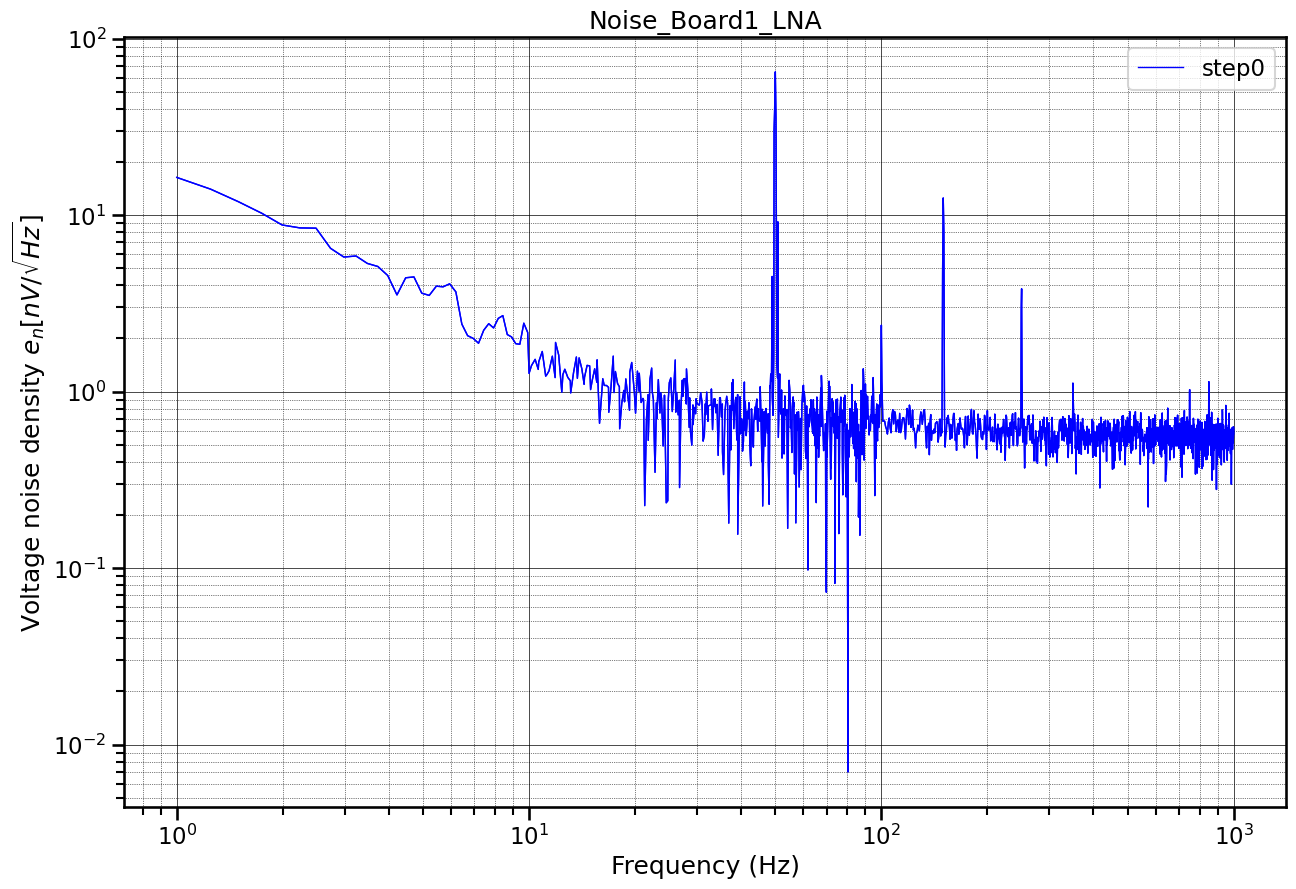

In [696]:
num = [[1]]
# num = [6]
step = ['step0']
# plt.figure(figsize = (15,10))
#-----------------
type = ['L']
for i in num:
        plot_noise_join_et_fit(i,type,step,1,0)
        # plt.ylim(20,3000)

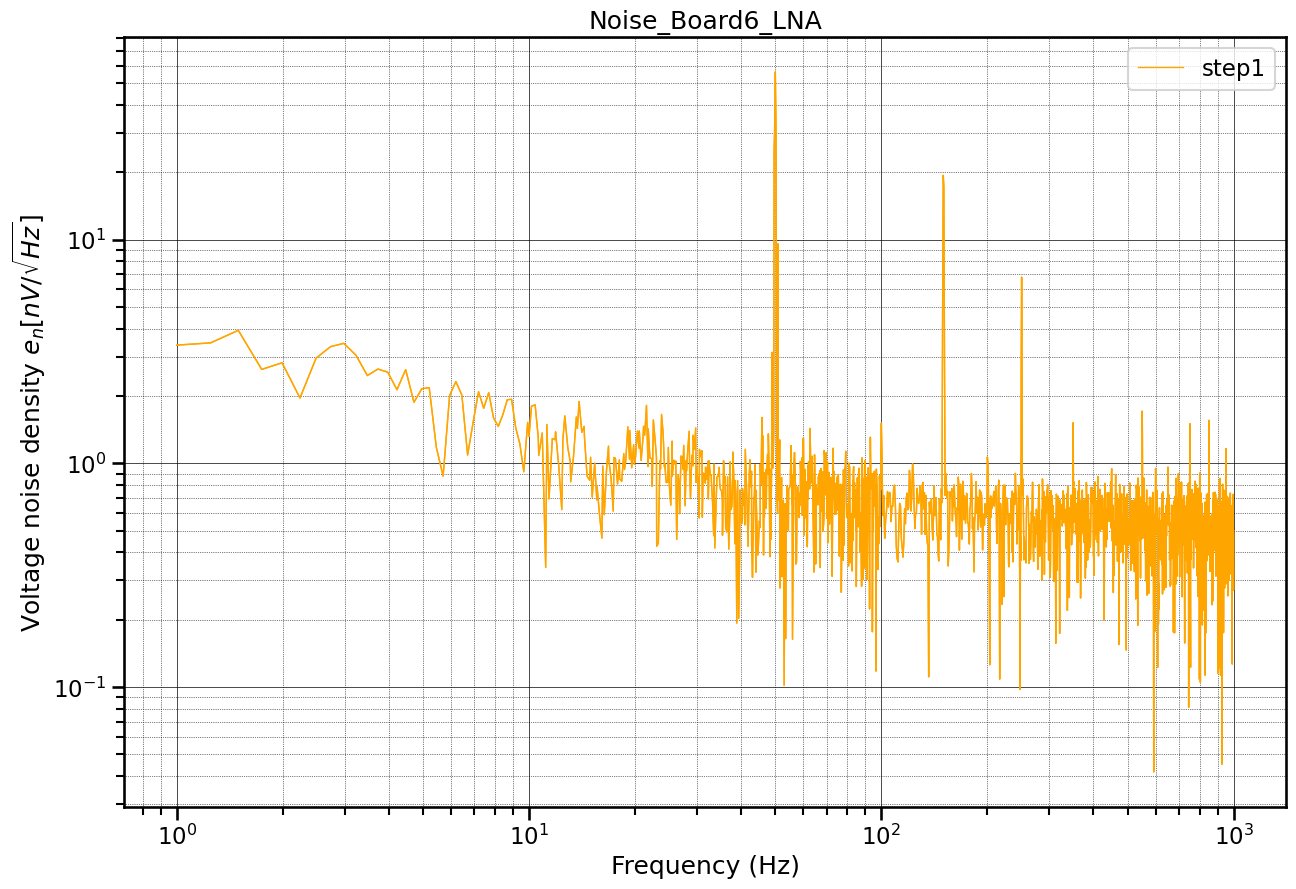

In [698]:
num = [[6]]
step = ['step1']
# plt.figure(figsize = (15,10))
#-----------------
type = ['L']
for i in num:
        plot_noise_join_et_fit(i,type,step,0,0)
        # plt.ylim(0.3,20)

In [701]:
num = [[1],[2],[3],[4],[5],[6]]
# num = [6]
step = ['step0','step1','step2','step3','step4','step5','step6','step7','step9']
# plt.figure(figsize = (15,10))
#-----------------
type = ['D']
for i in num:
        plot_noise_join_et_fit(i,type,step,2,1)
        # plt.ylim(20,3000)
#-----------------
# f = np.linspace(1,1000,1000)
# a = 11.568
# b = 2190.975
# c = 0.68
# plt.loglog(f,fit_curve(f,a,b,c),lw=1, label=f"Test $\sqrt{{({round(a, 3)})^2 + ({round(b, 3)})^2 / f^{{2*{round(c, 3)}}}}}$")
# plt.legend()

IndexError: list index out of range

In [ ]:
num = [[1],[2],[3],[4],[5],[6]]
step = ['step0','step1','step2','step3','step4','step5','step6','step7','step8','step9']
# plt.figure(figsize = (15,10))
#-----------------
type = ['L']
for i in num:
        plot_noise_join_et_fit(i,type,step,2,1)